In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as mvn
from sklearn.cluster import KMeans

In [2]:
data = sio.loadmat('data.mat')['data'].T
m,n = data.shape

In [3]:
# Perform PCA
C = np.matmul(data.T,data)/m
lambd, v = np.linalg.eig(C)
lambd = lambd.real
v = v.real
v = v[:,:4]

# Project data onto first 4 PCs to reduce dimension from 784 to 4 before applying EM
pdata = np.dot(data,v)

In [4]:
# Perform EM-GMM
k = 2
seed = 2

# Initialize prior
pi = np.random.random(k)
pi = pi/np.sum(pi)

# Initialize mean and covariance
mu = np.random.randn(k,4)
mu_old = mu.copy()

sigma = []

for i in range(k):
    temp = np.random.randn(4,4)
    sigma.append(temp@temp.T + np.eye(4))
    
# Initialize posterior
tau = np.full((m,k), fill_value = 0.)

maxIter = 100
tol = 1e-3

In [5]:
loglike = []
iterations = []

for i in range(maxIter):
    iterations.append(i)
    # E-step
    for kk in range(k):
        tau[:, kk] = pi[kk] * mvn.pdf(pdata, mu[kk], sigma[kk])
    # Normalize tau
    sum_tau = np.sum(tau, axis = 1)
    sum_tau.shape = (m,1)
    tau = np.divide(tau, np.tile(sum_tau, (1, k)))
    loglike.append(np.sum(np.log(sum_tau)))
    
    # M-step
    for kk in range(k):
        # Update prior
        pi[kk] = np.sum(tau[:,kk])/m
        # Update component mean
        mu[kk] = pdata.T @ tau[:,kk] / np.sum(tau[:,kk], axis = 0)
        # Update covariance matrix
        temp = pdata - np.tile(mu[kk], (m,1))
        sigma[kk] = temp.T @ np.diag(tau[:,kk]) @ temp / np.sum(tau[:,kk], axis = 0)
        
    print('---iteration---', i)
    if np.linalg.norm(mu - mu_old) < tol:
        print('training converged')
        break
    mu_old = mu.copy()
    if i == maxIter - 1:
        print('max iteration reached')
        break

---iteration--- 0
---iteration--- 1
---iteration--- 2
---iteration--- 3
---iteration--- 4
---iteration--- 5
---iteration--- 6
---iteration--- 7
---iteration--- 8
---iteration--- 9
training converged


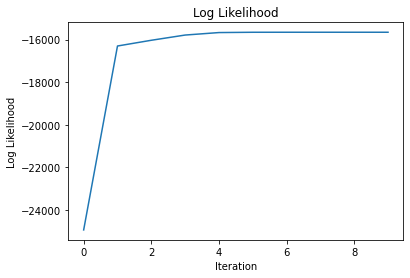

In [6]:
# Plot log likelihood function
plt.plot(iterations,loglike)
plt.xlabel('Iteration')
plt.ylabel('Log Likelihood')
plt.title('Log Likelihood')
plt.savefig('Log likelihood')

In [7]:
# Weights and means for each component
pi, mu

(array([0.51345586, 0.48654414]),
 array([[-6.86339336, -1.98123594, -0.07011164,  0.47647439],
        [-7.00029018,  2.19899072,  0.08348307, -0.31356366]]))

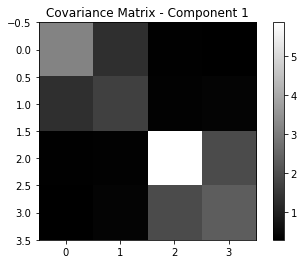

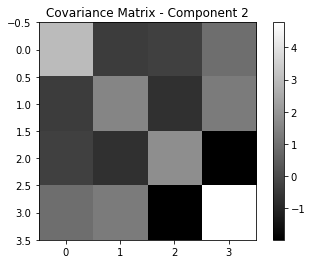

In [8]:
# Plot covariances matrices for the two Gaussians
plt.imshow(sigma[0], cmap='gray')
plt.colorbar()
plt.title('Covariance Matrix - Component 1')
plt.show()

plt.imshow(sigma[1], cmap='gray')
plt.colorbar()
plt.title('Covariance Matrix - Component 2')
plt.show()

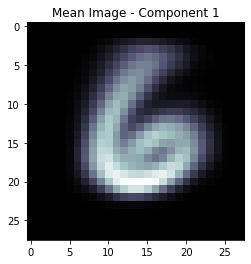

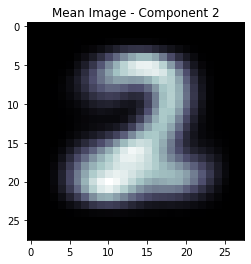

In [9]:
# Map the weights for each cluster back to the original data to find average images and plot
plt.imshow((data.T @ tau[:,0]).reshape(28,28).T, cmap = 'bone')
plt.title('Mean Image - Component 1')
plt.show()

plt.imshow((data.T @ tau[:,1]).reshape(28,28).T, cmap = 'bone')
plt.title('Mean Image - Component 2')
plt.show()

In [10]:
# Calculate misclassification rate
labels = sio.loadmat('label.mat')['trueLabel'][0]
mod_labels = np.where(tau > 0.5)[1]

correct_labels = 0
correct_2 = 0
correct_6 = 0

for m,t in zip(mod_labels, labels):
    if m == 0 and t == 2:
        correct_2 += 1
        correct_labels += 1
    elif m == 1 and t == 6:
        correct_6 += 1
        correct_labels += 1
    
mc_total = 1 - correct_labels/1990

if mc_total > 0.9:
    mc_total = 1 - mc_total
    mc_2 = correct_2/np.where(labels == 2)[0].shape[0]
    mc_6 = correct_6/np.where(labels == 6)[0].shape[0]
else:
    mc_2 = 1 - correct_2/np.where(labels == 2)[0].shape[0]
    mc_6 = 1 - correct_6/np.where(labels == 6)[0].shape[0]

print('Total MC Rate = {}'.format(round(mc_total,4)))
print('2 MC Rate = {}'.format(round(mc_2,4)))
print('6 MC Rate = {}'.format(round(mc_6,4)))

Total MC Rate = 0.0377
2 MC Rate = 0.064
6 MC Rate = 0.0094


In [11]:
# Run K-means clustering on the data set for performance comparison
kmeans = KMeans(n_clusters=2).fit(pdata)
kmeans.cluster_centers_

array([[-6.85932978,  2.08733003,  0.10419006, -0.21304647],
       [-7.00814794, -2.19738463, -0.10548875,  0.42950763]])

In [12]:
# Calculate kmeans misclassification rates
correct_labels = 0
correct_2 = 0
correct_6 = 0

for m,t in zip(kmeans.labels_, labels):
    if m == 0 and t == 2:
        correct_2 += 1
        correct_labels += 1
    elif m == 1 and t == 6:
        correct_6 += 1
        correct_labels += 1
    
mc_total = 1 - correct_labels/1990

if mc_total > 0.9:
    mc_total = 1 - mc_total
    mc_2 = correct_2/np.where(labels == 2)[0].shape[0]
    mc_6 = correct_6/np.where(labels == 6)[0].shape[0]
else:
    mc_2 = 1 - correct_2/np.where(labels == 2)[0].shape[0]
    mc_6 = 1 - correct_6/np.where(labels == 6)[0].shape[0]

print('Total MC Rate = {}'.format(round(mc_total,4)))
print('2 MC Rate = {}'.format(round(mc_2,4)))
print('6 MC Rate = {}'.format(round(mc_6,4)))

Total MC Rate = 0.0704
2 MC Rate = 0.062
6 MC Rate = 0.0793
